In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile
import pandas as pd

## Data Load

In [ ]:
file_path1 = '../data/1_9.tdms'
file_path2 = '../data/10.tdms'

tdms1 = TdmsFile.read(file_path1)
tdms2 = TdmsFile.read(file_path2)

print("✅ Available groups and channels:")
group_channel_map = {}
for grp in tdms1.groups():
    name = grp.name
    channels = [ch.name for ch in grp.channels()]
    group_channel_map[name] = channels
    print(f" - Group: {name}")
    for ch in channels:
        print(f"    • {ch}")



✅ Available groups and channels:
 - Group: Datas
    • Time (ms)
    • Reference Position X
    • Reference Position Y
    • Measured Position X
    • Measured Position Y
    • Reference Tension L
    • Reference Tension R
    • Reference Tension T
    • Measured Tension L
    • Measured Tension R
    • Measured Tension T
    • RBF1
    • RBF2
    • RBF3
    • RBF4
    • RBF5
    • Trajectory
    • Projected Force
    • Force X
    • Force Y
    • Damp1
    • Damp2
    • Damp3
    • Damp4
    • Damp5


### Data Concat

In [4]:
# DataFrame으로 변환 (group 이름을 실제로 맞춰야 함)
df1 = tdms1['Datas'].as_dataframe()  # 'Data' → 실제 그룹명
df2 = tdms2['Datas'].as_dataframe()

# concat으로 이어붙이기
df_concat = pd.concat([df1, df2], ignore_index=True)

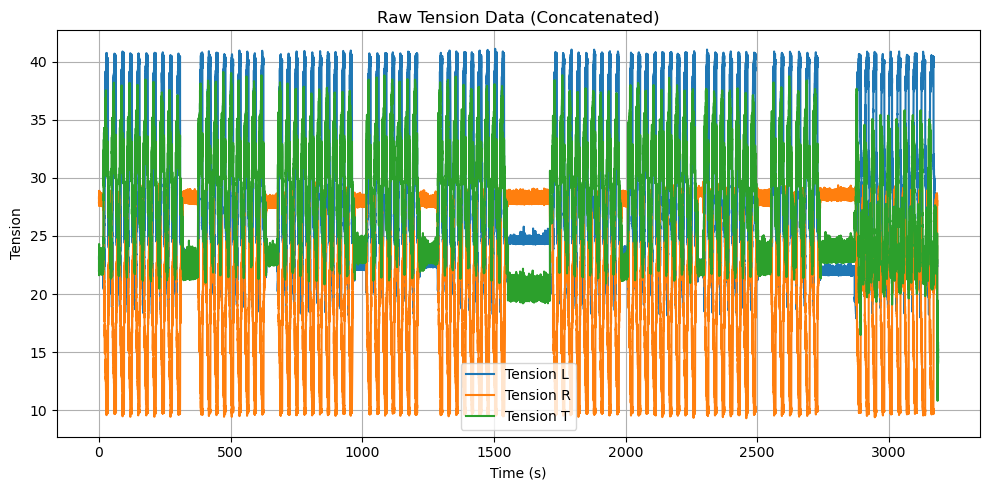

In [5]:
import matplotlib.pyplot as plt

# 필요한 컬럼 이름이 정확히 아래와 같다고 가정 ("Measured Tension L" 등)
ten_l = df_concat['Measured Tension L']
ten_r = df_concat['Measured Tension R']
ten_t = df_concat['Measured Tension T']

# 시간축 생성 (총 데이터 길이 / 샘플레이트)
sample_rate = 50  # Hz
time = np.arange(len(df_concat)) / sample_rate

plt.figure(figsize=(10,5))
plt.plot(time, ten_l, color='C0', label='Tension L')
plt.plot(time, ten_r, color='C1', label='Tension R')
plt.plot(time, ten_t, color='C2', label='Tension T')
plt.title('Raw Tension Data (Concatenated)')
plt.xlabel('Time (s)')
plt.ylabel('Tension')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Data Group

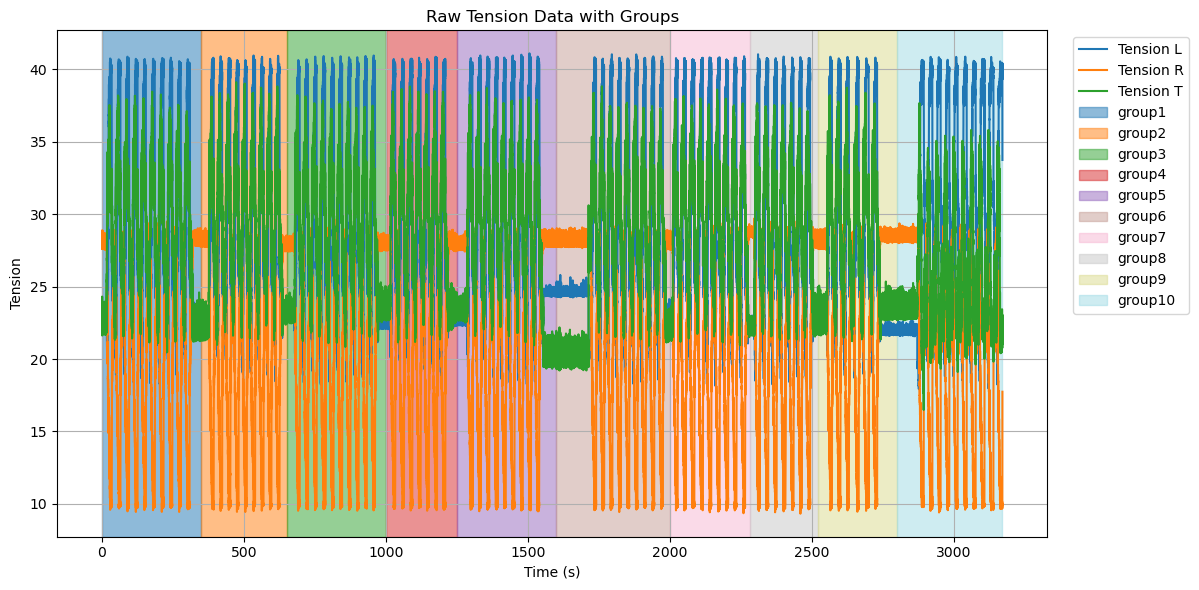

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample_rate = 50
time = np.arange(len(df_concat)) / sample_rate

split_times = [350, 650, 1000, 1250, 1600, 2000, 2280, 2520, 2800, 3170]
group_data = {}
start_time = 0
group_names = []

for idx, end_time in enumerate(split_times):
    mask = (time >= start_time) & (time < end_time)
    group_name = f'group{idx+1}'
    group_data[group_name] = df_concat[mask]
    group_names.append((start_time, end_time, group_name))
    start_time = end_time

if start_time < time[-1]:
    group_name = f'group{len(split_times)+1}'
    mask = (time >= start_time)
    group_data[group_name] = df_concat[mask]
    group_names.append((start_time, time[-1], group_name))

# ---- 여기부터 색깔 다르게 ----
colors = plt.colormaps['tab20'].resampled(len(group_names))

plt.figure(figsize=(12,6))
plt.plot(time, df_concat['Measured Tension L'], label='Tension L')
plt.plot(time, df_concat['Measured Tension R'], label='Tension R')
plt.plot(time, df_concat['Measured Tension T'], label='Tension T')

for i, (start, end, name) in enumerate(group_names):
    plt.axvspan(start, end, color=colors(i), alpha=0.5, label=name)

plt.title('Raw Tension Data with Groups')
plt.xlabel('Time (s)')
plt.ylabel('Tension')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Weight Update

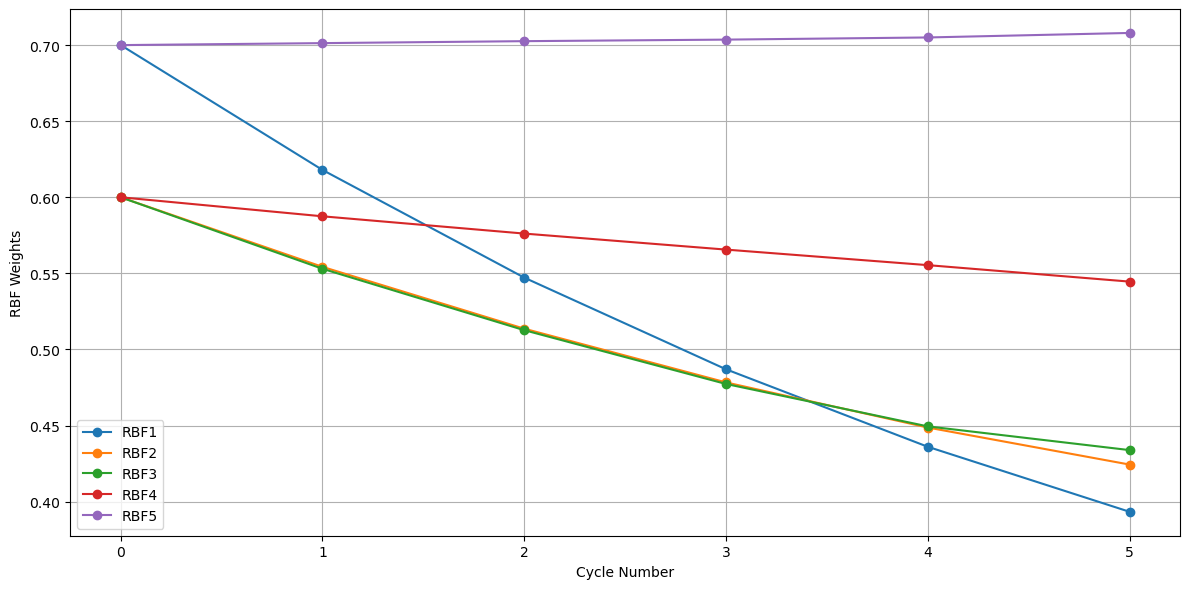

In [72]:
df_g1 = group_data['group9']

traj = df_g1['Trajectory'].values
w1 = df_g1['RBF1'].values
w2 = df_g1['RBF2'].values
w3 = df_g1['RBF3'].values
w4 = df_g1['RBF4'].values
w5 = df_g1['RBF5'].values

# rising edge 인덱스만 뽑기
rising_idx = np.where((traj[:-1] == 0) & (traj[1:] == 1))[0] + 1

w1_rise = w1[rising_idx]
w2_rise = w2[rising_idx]
w3_rise = w3[rising_idx]
w4_rise = w4[rising_idx]
w5_rise = w5[rising_idx]

cycle_nums = np.arange(len(rising_idx))

plt.figure(figsize=(12,6))
plt.plot(cycle_nums, w1_rise, '-o', color='C0', label='RBF1')
plt.plot(cycle_nums, w2_rise, '-o', color='C1', label='RBF2')
plt.plot(cycle_nums, w3_rise, '-o', color='C2', label='RBF3')
plt.plot(cycle_nums, w4_rise, '-o', color='C3', label='RBF4')
plt.plot(cycle_nums, w5_rise, '-o', color='C4', label='RBF5')
plt.xlabel('Cycle Number')
plt.ylabel('RBF Weights')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


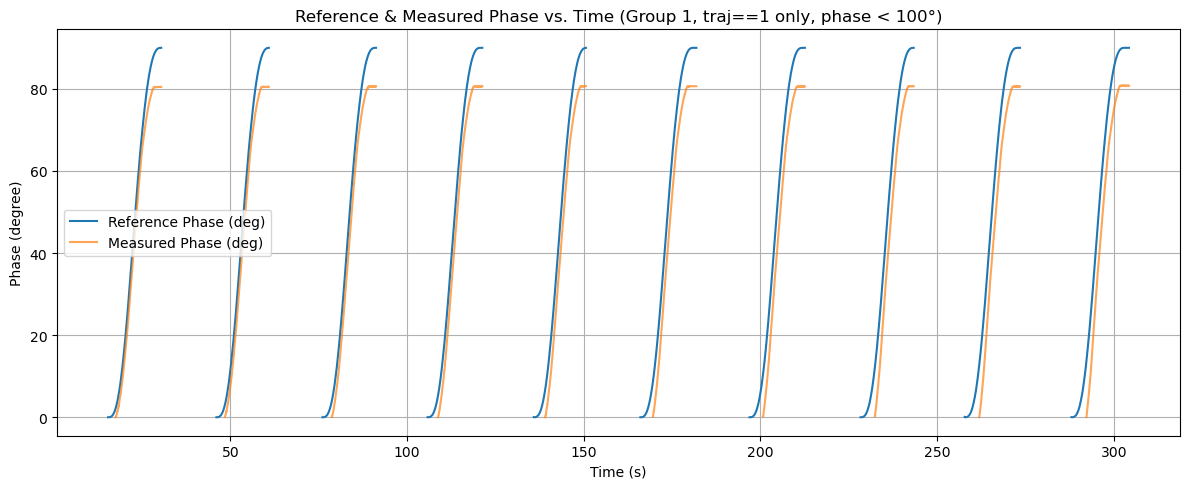

In [8]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group1']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
traj  = df_g1['Trajectory'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

# phase 전체를 NaN으로 초기화 (degree)
phase_ref_deg = np.full_like(ref_x, np.nan, dtype=np.float64)
phase_act_deg = np.full_like(act_x, np.nan, dtype=np.float64)

# traj == 1인 구간만 계산
mask = (traj == 1)
phase_ref = (np.arctan2(ref_y[mask], ref_x[mask]) + 2 * np.pi) % (2 * np.pi)
phase_ref_deg[mask] = np.degrees(phase_ref)

phase_act = (np.arctan2(act_y[mask], act_x[mask]) + 2 * np.pi) % (2 * np.pi)
phase_act_deg[mask] = np.degrees(phase_act)

def clamp_phase(arr, thresh=100):
    arr_fixed = arr.copy()
    # 100~360도는 NaN
    arr_fixed[(arr_fixed > thresh) & (arr_fixed <= 360)] = np.nan
    return arr_fixed

phase_ref_deg = clamp_phase(phase_ref_deg, thresh=100)
phase_act_deg = clamp_phase(phase_act_deg, thresh=100)

plt.figure(figsize=(12,5))
plt.plot(time, phase_ref_deg, label='Reference Phase (deg)')
plt.plot(time, phase_act_deg, label='Measured Phase (deg)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Phase (degree)')
plt.title('Reference & Measured Phase vs. Time (Group 1, traj==1 only, phase < 100°)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def phase_overlay_for_groupname(
    df, group_data, group_name, split_times,
    sample_rate=50, cut_sec=15, num_cycles=8, base_color='C0',
    plot=True, return_segments=False
):
    idx = int(group_name.replace('group','')) - 1
    if idx == 0:
        start_time = 0
        end_time = split_times[0]
    elif idx < len(split_times):
        start_time = split_times[idx-1]
        end_time = split_times[idx]
    else:
        start_time = split_times[-1]
        end_time = np.arange(len(df))[-1] / sample_rate

    time = np.arange(len(df)) / sample_rate
    mask = (time >= start_time) & (time < end_time)
    df_sub = df.loc[mask].reset_index(drop=True)

    traj_raw = df_sub['Trajectory'].values
    traj_bin = (traj_raw > 0.5).astype(int)
    ref_x = df_sub['Reference Position X'].values
    ref_y = df_sub['Reference Position Y'].values
    act_x = df_sub['Measured Position X'].values
    act_y = df_sub['Measured Position Y'].values

    # Phase: -180~180도
    phase_ref_deg = np.degrees((np.arctan2(ref_y, ref_x) + 2*np.pi) % (2*np.pi))
    phase_act_deg = np.degrees((np.arctan2(act_y, act_x) + 2*np.pi) % (2*np.pi))
    phase_ref_deg = ((phase_ref_deg + 180) % 360) - 180
    phase_act_deg = ((phase_act_deg + 180) % 360) - 180

    cut_len = int(cut_sec * sample_rate)
    rising_idx = np.where((traj_bin[:-1] == 0) & (traj_bin[1:] == 1))[0] + 1

    segments_act, segments_ref = [], []
    for s in rising_idx[-num_cycles:]:
        if s + cut_len <= len(traj_bin):
            seg_act = phase_act_deg[s:s+cut_len].copy()
            seg_ref = phase_ref_deg[s:s+cut_len].copy()
            segments_act.append(seg_act)
            segments_ref.append(seg_ref)

    if not segments_act:
        if return_segments:
            return None, None, None
        return

    segments_act = np.vstack(segments_act)
    segments_ref = np.vstack(segments_ref)
    t_short = np.arange(cut_len) / sample_rate

    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(t_short, segments_ref[-1], color='black', linestyle='--', linewidth=2.5, label='Reference (last)')
        for idx2, seg in enumerate(segments_act):
            alpha = 0.3 + 0.7 * (idx2+1)/len(segments_act)
            lw = 1.5 if idx2 < len(segments_act)-1 else 3
            label = f'Cycle {idx2+1}' if idx2 < len(segments_act)-1 else f'Cycle {idx2+1} (last)'
            plt.plot(t_short, seg, color=base_color, alpha=alpha, lw=lw, label=label)
        plt.xlabel('Time [s]')
        plt.ylabel('Phase [deg] (-180~180)')
        plt.title(f'Overlay: {group_name} [{start_time}s, {end_time}s] ({len(segments_act)} cycles, each {cut_sec}s)')
        plt.legend(ncol=2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if return_segments:
        return segments_act, segments_ref, t_short


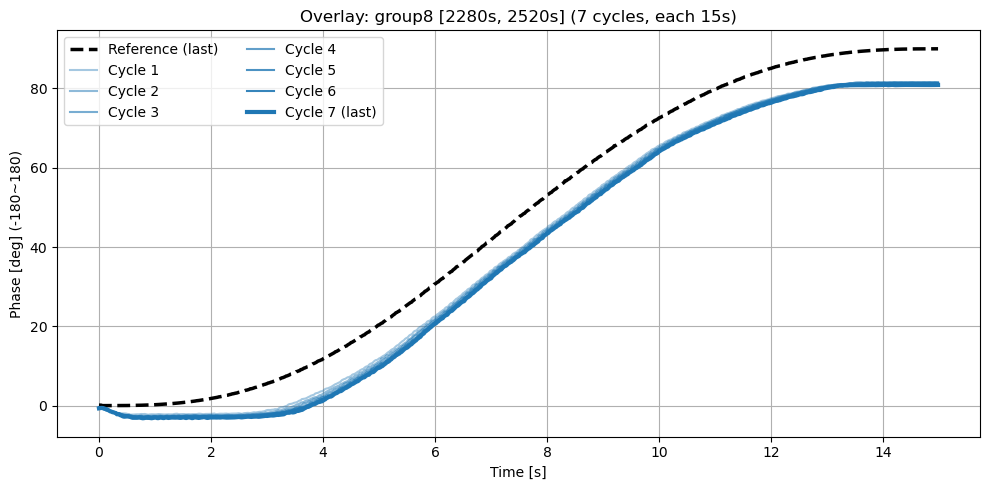

In [20]:
# group1 overlay plot
phase_overlay_for_groupname(
    df_concat, group_data, 'group8', split_times, base_color='C0', plot=True, return_segments=False
)


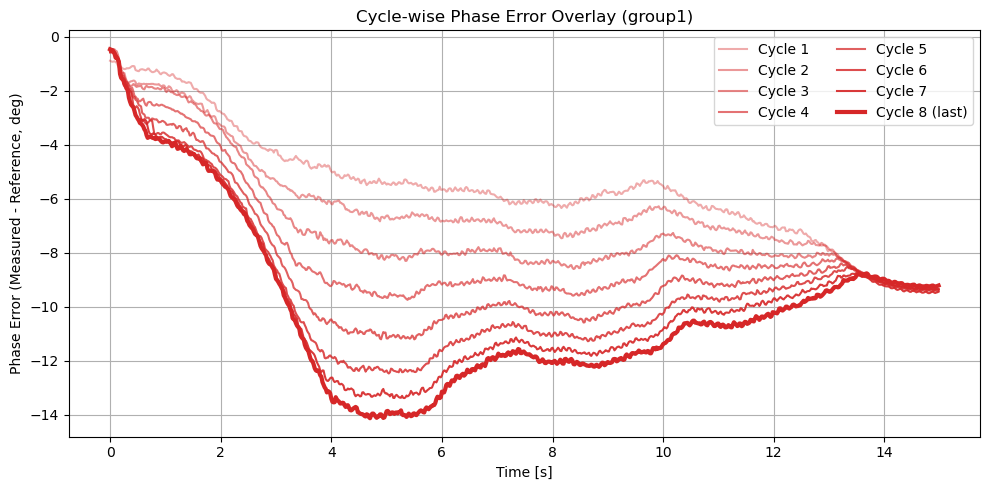

In [14]:
segments_act, segments_ref, t_short = phase_overlay_for_groupname(
    df_concat, group_data, 'group1', split_times, base_color='C0', plot=False, return_segments=True
)

if segments_act is None or segments_ref is None:
    print("에러 계산을 위한 데이터가 없습니다.")
else:
    phase_error = segments_act - segments_ref
    plt.figure(figsize=(10,5))
    base_color = 'C3'
    for idx, err in enumerate(phase_error):
        alpha = 0.3 + 0.7 * (idx+1)/phase_error.shape[0]
        lw = 1.5 if idx < phase_error.shape[0]-1 else 3
        label = f'Cycle {idx+1}' if idx < phase_error.shape[0]-1 else f'Cycle {idx+1} (last)'
        plt.plot(t_short, err, color=base_color, alpha=alpha, lw=lw, label=label)
    plt.xlabel('Time [s]')
    plt.ylabel('Phase Error (Measured - Reference, deg)')
    plt.title('Cycle-wise Phase Error Overlay (group1)')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


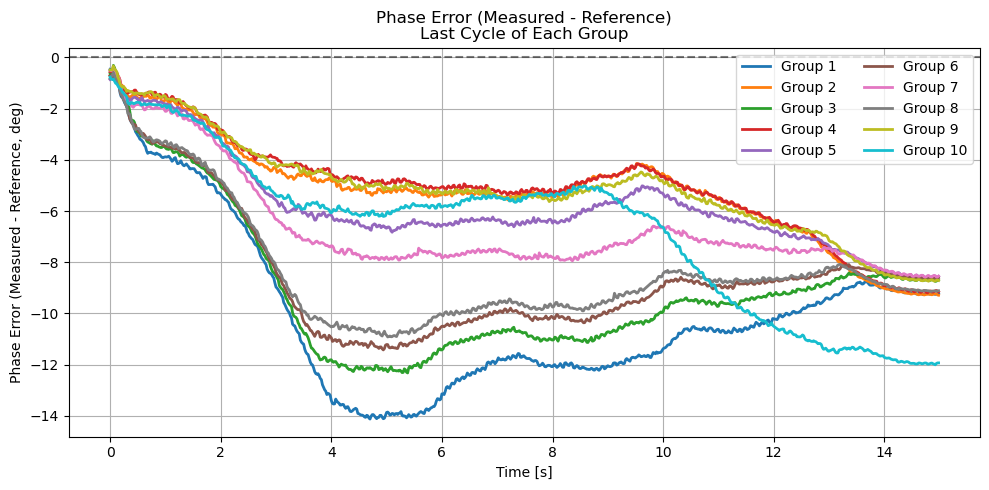

In [15]:
group_names = [f'group{i+1}' for i in range(len(split_times)+1)]
last_errors = []
t_short = None

for group_name in group_names:
    segments_act, segments_ref, t_ = phase_overlay_for_groupname(
        df_concat, group_data, group_name, split_times,
        base_color='C0', plot=False, return_segments=True
    )
    if segments_act is not None and segments_ref is not None and len(segments_act) > 0:
        err = segments_act[-1] - segments_ref[-1]
        last_errors.append(err)
        t_short = t_

if not last_errors:
    print("마지막 사이클 에러가 없습니다.")
else:
    plt.figure(figsize=(10,5))
    colors = plt.colormaps['tab10'].resampled(len(last_errors))
    for idx, err in enumerate(last_errors):
        plt.plot(t_short, err, color=colors(idx), lw=2, label=f'Group {idx+1}')
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Time [s]')
    plt.ylabel('Phase Error (Measured - Reference, deg)')
    plt.title('Phase Error (Measured - Reference)\nLast Cycle of Each Group')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


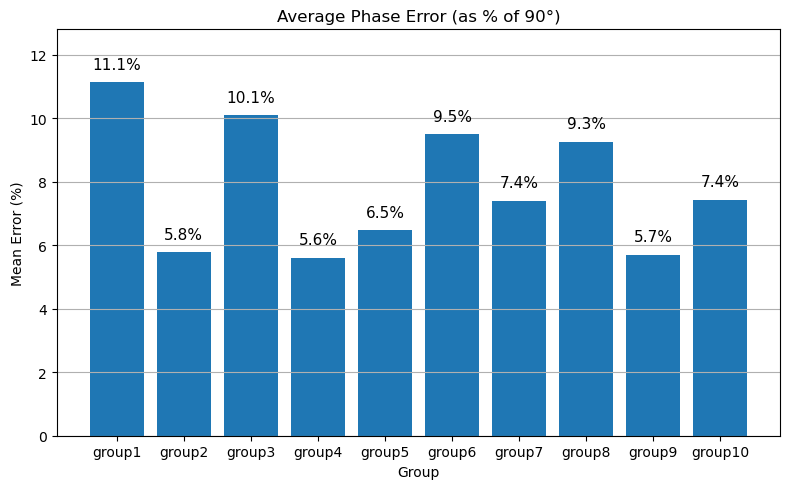

In [16]:
import numpy as np
import matplotlib.pyplot as plt

group_names = [f'group{i+1}' for i in range(len(split_times)+1)]
last_errors = []
mean_errors = []
t_short = None

# 목표값(예: 90도)
target_deg = 90

for group_name in group_names:
    segments_act, segments_ref, t_ = phase_overlay_for_groupname(
        df_concat, group_data, group_name, split_times,
        base_color='C0', plot=False, return_segments=True
    )
    if segments_act is not None and segments_ref is not None and len(segments_act) > 0:
        err = segments_act[-1] - segments_ref[-1]
        last_errors.append(err)
        mean_err = np.nanmean(np.abs(err))   # 평균절대오차(혹은 np.nanmean(err)로 바꿀 수도)
        mean_errors.append(mean_err)
        t_short = t_

# 에러 퍼센트 계산
error_perc = [100 * e / target_deg for e in mean_errors]

# bar plot
plt.figure(figsize=(8,5))
plt.bar(group_names, error_perc, color='C0')
plt.ylabel('Mean Error (%)')
plt.xlabel('Group')
plt.ylim(0, max(error_perc)*1.15)
plt.title(f'Average Phase Error (as % of {target_deg}°)')
plt.grid(axis='y')
for i, perc in enumerate(error_perc):
    plt.text(i, perc + max(error_perc)*0.03, f'{perc:.1f}%', ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()


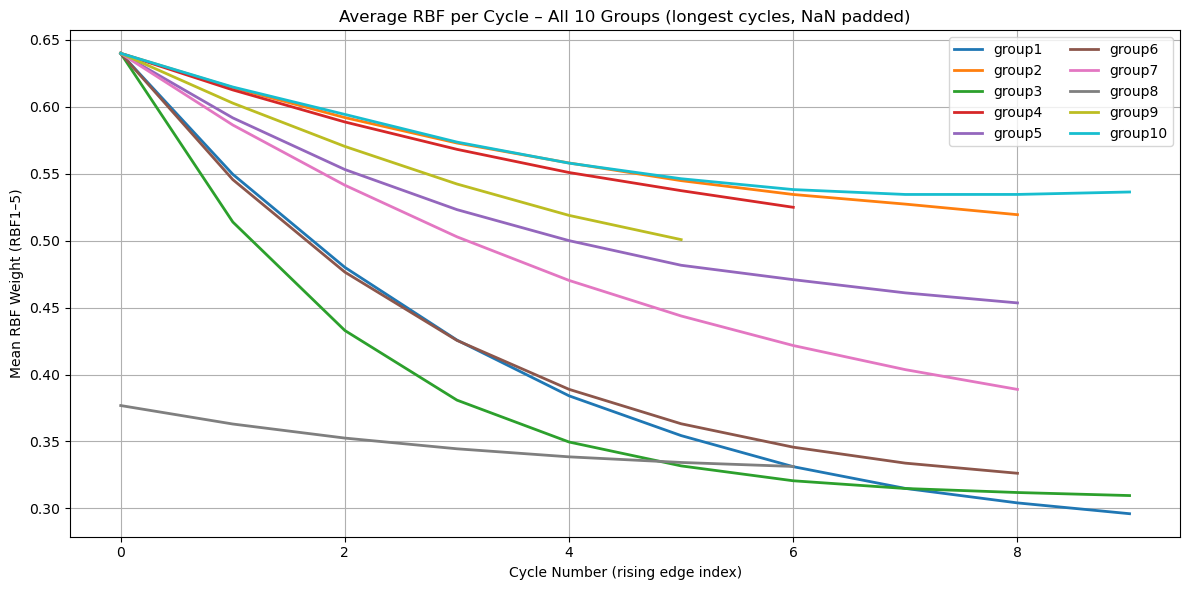

In [18]:
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 50
num_groups   = 10
groups       = [f'group{i+1}' for i in range(num_groups)]

avg_curves   = []
max_cycles   = 0

# ---------- 각 그룹별 평균 RBF 곡선 구하기 ----------
for gname in groups:
    if gname not in group_data:
        print(f'{gname} 없음'); continue
    df_g = group_data[gname]

    traj = df_g['Trajectory'].values.astype(int)
    rising_idx = np.where((traj[:-1]==0) & (traj[1:]==1))[0] + 1
    cycle_n    = len(rising_idx)
    max_cycles = max(max_cycles, cycle_n)

    # 5개 RBF 평균
    w_mean = np.vstack([df_g[f'RBF{i}'].values[rising_idx] for i in range(1,6)]).mean(axis=0)
    avg_curves.append(w_mean)

# ---------- 가장 긴 cycle 수로 맞추고, 부족한 부분은 NaN ----------
avg_curves_padded = []
for c in avg_curves:
    if len(c) < max_cycles:
        pad = np.full(max_cycles - len(c), np.nan)
        c_padded = np.concatenate([c, pad])
    else:
        c_padded = c
    avg_curves_padded.append(c_padded)

cycle_nums = np.arange(max_cycles)

# ---------- 플롯 ----------
plt.figure(figsize=(12,6))
colors = plt.colormaps['tab10'].resampled(len(avg_curves_padded))
for idx, curve in enumerate(avg_curves_padded):
    plt.plot(cycle_nums, curve,
             color=colors(idx),
             lw=2,
             label=f'{groups[idx]}')

plt.xlabel('Cycle Number (rising edge index)')
plt.ylabel('Mean RBF Weight (RBF1–5)')
plt.title('Average RBF per Cycle – All 10 Groups (longest cycles, NaN padded)')
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
num_groups = 10
groups = [f'group{i+1}' for i in range(num_groups)]

print("각 그룹의 마지막 사이클 stiffness(평균 RBF1~5):")
for gname in groups:
    if gname not in group_data:
        print(f"{gname}: 데이터 없음")
        continue
    df_g = group_data[gname]

    traj = df_g['Trajectory'].values.astype(int)
    rising_idx = np.where((traj[:-1]==0) & (traj[1:]==1))[0] + 1
    if len(rising_idx) == 0:
        print(f"{gname}: rising edge 없음")
        continue

    # 마지막 rising 위치
    last_idx = rising_idx[-1]

    # 마지막 사이클의 RBF1~5 추출
    rbf_vals = [df_g[f'RBF{i}'].values[last_idx] for i in range(1, 6)]
    stiffness = np.mean(rbf_vals)
    print(f"{gname}:  {stiffness:.4f}")


각 그룹의 마지막 사이클 stiffness(평균 RBF1~5):
group1:  0.2960
group2:  0.5194
group3:  0.3096
group4:  0.5250
group5:  0.4535
group6:  0.3262
group7:  0.3889
group8:  0.3313
group9:  0.5008
group10:  0.5364


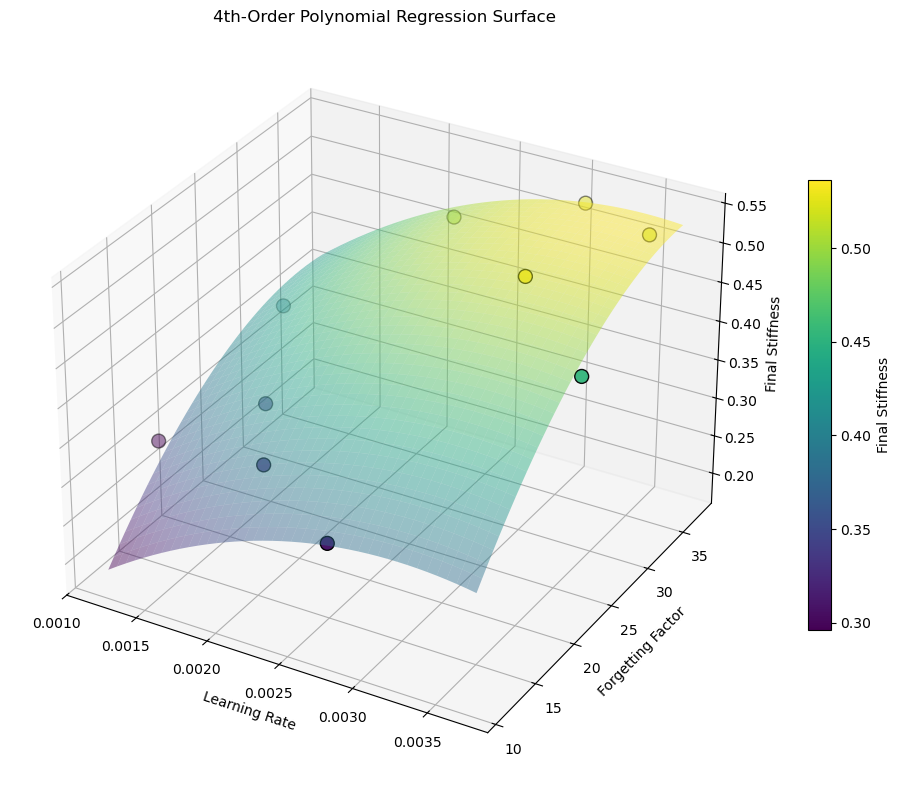

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 데이터 (동일)
learning_rates = np.array([0.002727, 0.001184, 0.003054, 0.003713, 0.003552,
                           0.002027, 0.001434, 0.001684, 0.003237, 0.002330])
forgetting_factors = np.array([10.929426, 17.070128, 37.226569, 23.850585, 35.939942,
                               15.498528, 28.044593, 21.540005, 25.703203, 33.698206])
group_order = [3, 1, 4, 5, 2, 6, 7, 8, 10, 9]
stiffness_list = []
for gname in [f'group{i}' for i in group_order]:
    df_g = group_data[gname]
    traj = df_g['Trajectory'].values.astype(int)
    rising_idx = np.where((traj[:-1]==0) & (traj[1:]==1))[0] + 1
    rbf_vals = [df_g[f'RBF{i}'].values[rising_idx[-1]] for i in range(1, 6)]
    stiffness = np.mean(rbf_vals)
    stiffness_list.append(stiffness)
stiffness_arr = np.array(stiffness_list)

# Polynomial Regression (4차)
deg = 2
X = np.column_stack((learning_rates, forgetting_factors))
poly = PolynomialFeatures(degree=deg)
X_poly = poly.fit_transform(X)
reg = LinearRegression().fit(X_poly, stiffness_arr)

# 평면 grid
lr_grid, ff_grid = np.meshgrid(
    np.linspace(learning_rates.min(), learning_rates.max(), 40),
    np.linspace(forgetting_factors.min(), forgetting_factors.max(), 40)
)
X_grid = np.column_stack([lr_grid.ravel(), ff_grid.ravel()])
Z_grid = reg.predict(poly.transform(X_grid)).reshape(lr_grid.shape)

# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# 데이터 산점
sc = ax.scatter(learning_rates, forgetting_factors, stiffness_arr, c=stiffness_arr,
                cmap='viridis', s=100, edgecolor='k')
for i, (x, y, z) in enumerate(zip(learning_rates, forgetting_factors, stiffness_arr)):
    ax.text(x, y, z+0.7, f'{group_order[i]}', color='k', fontsize=11, ha='center', va='bottom')

# 4차 회귀 서피스
ax.plot_surface(lr_grid, ff_grid, Z_grid, alpha=0.45, cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=True)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Forgetting Factor')
ax.set_zlabel('Final Stiffness')
ax.set_title('4th-Order Polynomial Regression Surface')
fig.colorbar(sc, ax=ax, shrink=0.6, label='Final Stiffness')
plt.tight_layout()
plt.show()


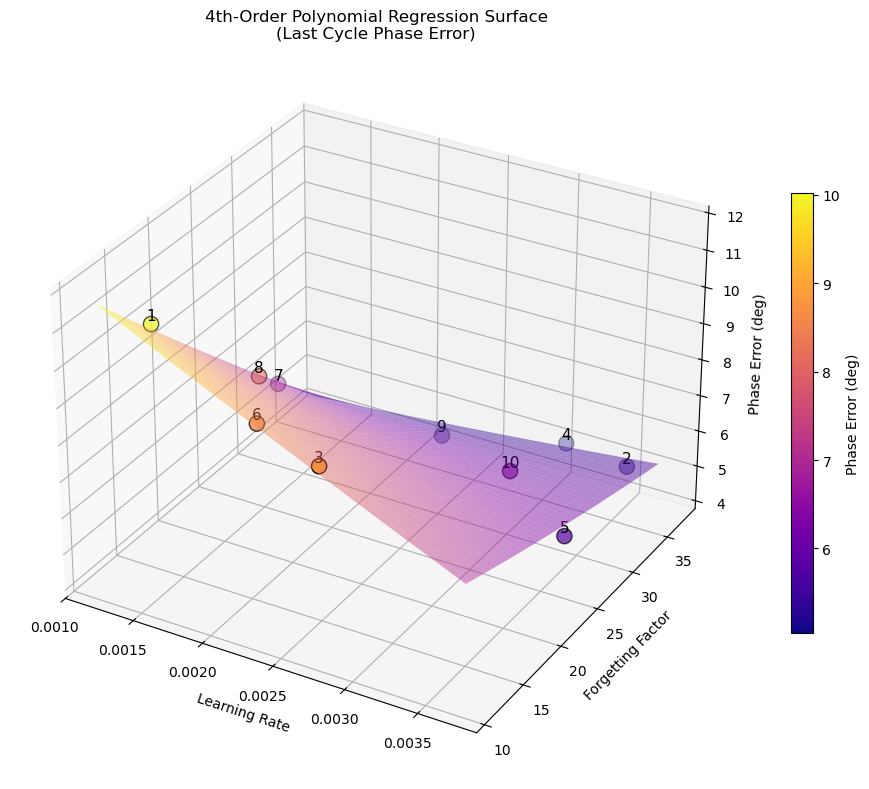

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 파라미터
learning_rates = np.array([0.002727, 0.001184, 0.003054, 0.003713, 0.003552,
                           0.002027, 0.001434, 0.001684, 0.003237, 0.002330])
forgetting_factors = np.array([10.929426, 17.070128, 37.226569, 23.850585, 35.939942,
                               15.498528, 28.044593, 21.540005, 25.703203, 33.698206])
group_order = [3, 1, 4, 5, 2, 6, 7, 8, 10, 9]

# 그룹별 마지막 사이클 에러(예: 평균절대값, 원하는 error_metric으로 바꿔도 OK)
error_list = []
for gname in [f'group{i}' for i in group_order]:
    segments_act, segments_ref, _ = phase_overlay_for_groupname(
        df_concat, group_data, gname, split_times, base_color='C0', plot=False, return_segments=True
    )
    if segments_act is not None and segments_ref is not None and len(segments_act) > 0:
        err = segments_act[-1] - segments_ref[-1]
        mean_err = np.nanmean(np.abs(err))  # 평균절대오차, 또는 np.nanmean(err)
        error_list.append(mean_err)
    else:
        error_list.append(np.nan)  # 데이터 없는 그룹은 NaN

error_arr = np.array(error_list)

# 3D Polynomial Regression (4차)
deg = 2
X = np.column_stack((learning_rates, forgetting_factors))
poly = PolynomialFeatures(degree=deg)
X_poly = poly.fit_transform(X)
reg = LinearRegression().fit(X_poly, error_arr)

# Grid
lr_grid, ff_grid = np.meshgrid(
    np.linspace(learning_rates.min(), learning_rates.max(), 40),
    np.linspace(forgetting_factors.min(), forgetting_factors.max(), 40)
)
X_grid = np.column_stack([lr_grid.ravel(), ff_grid.ravel()])
Z_grid = reg.predict(poly.transform(X_grid)).reshape(lr_grid.shape)

# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter: 각 그룹 에러
sc = ax.scatter(learning_rates, forgetting_factors, error_arr, c=error_arr,
                cmap='plasma', s=120, edgecolor='k')
for i, (x, y, z) in enumerate(zip(learning_rates, forgetting_factors, error_arr)):
    ax.text(x, y, z+0.03, f'{group_order[i]}', color='k', fontsize=11, ha='center', va='bottom')

# Surface: 다항 회귀
ax.plot_surface(lr_grid, ff_grid, Z_grid, alpha=0.45, cmap='plasma', rstride=1, cstride=1, linewidth=0, antialiased=True)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Forgetting Factor')
ax.set_zlabel('Phase Error (deg)')
ax.set_title('4th-Order Polynomial Regression Surface\n(Last Cycle Phase Error)')
fig.colorbar(sc, ax=ax, shrink=0.6, label='Phase Error (deg)')
plt.tight_layout()
plt.show()


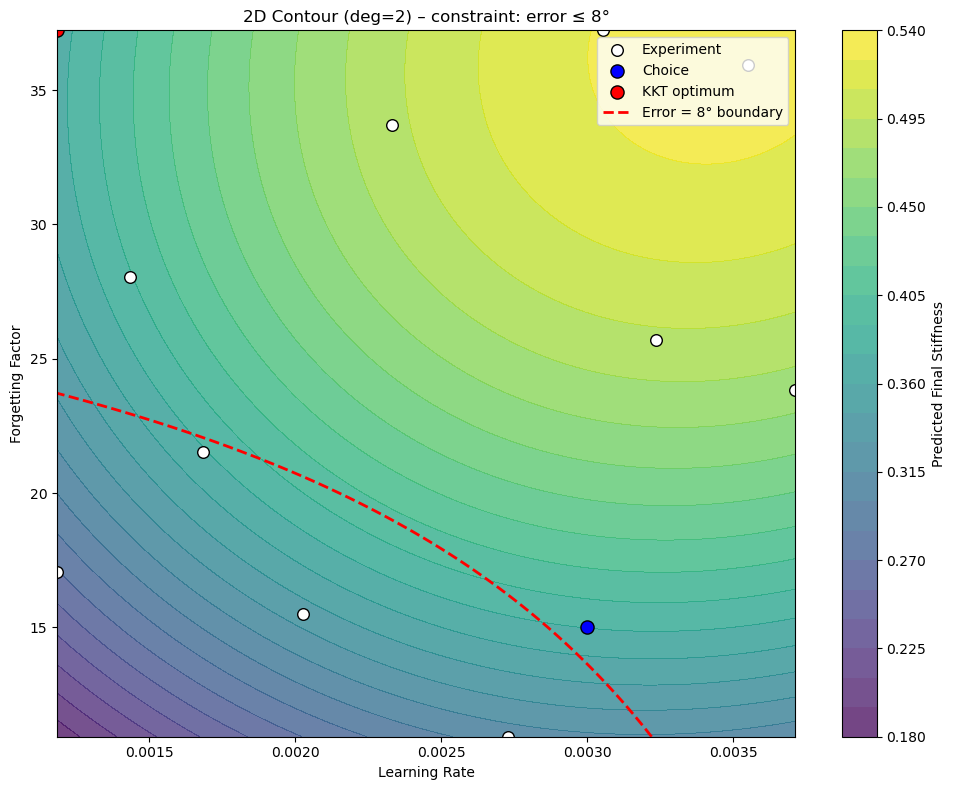

[User Choice] lr=0.003, ff=15  →  stiff=0.375, err=7.808°
[KKT Optimum] lr=0.001184, ff=37.226569  →  stiff=0.367, err=4.310°


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# ───────────────────────
# 0) 사용자 설정
err_threshold = 8         # ★ 여기 숫자만 바꿔주세요!
deg           = 2          # 회귀 다항 차수
# ───────────────────────

# 1) 실험 데이터 ---------------------------------------------------------
learning_rates     = np.array([0.002727,0.001184,0.003054,0.003713,0.003552,
                               0.002027,0.001434,0.001684,0.003237,0.002330])
forgetting_factors = np.array([10.929426,17.070128,37.226569,23.850585,35.939942,
                               15.498528,28.044593,21.540005,25.703203,33.698206])
group_order        = [3,1,4,5,2,6,7,8,10,9]

stiffness_arr, error_arr = [], []
for gname in [f'group{i}' for i in group_order]:
    seg_act, seg_ref, _ = phase_overlay_for_groupname(df_concat, group_data, gname,
                                                      split_times, plot=False, return_segments=True)
    if seg_act is None:
        stiffness_arr.append(np.nan); error_arr.append(np.nan); continue

    df_g   = group_data[gname]
    traj   = df_g['Trajectory'].values.astype(int)
    last_i = np.where((traj[:-1]==0)&(traj[1:]==1))[0][-1] + 1
    stiff  = np.mean([df_g[f'RBF{i}'].values[last_i] for i in range(1,6)])
    err    = np.nanmean(np.abs(seg_act[-1] - seg_ref[-1]))
    stiffness_arr.append(stiff); error_arr.append(err)

stiffness_arr = np.array(stiffness_arr); error_arr = np.array(error_arr)

# 2) 다항 회귀 모델 -----------------------------------------------------
X   = np.column_stack((learning_rates, forgetting_factors))
poly = PolynomialFeatures(degree=deg)
reg_s = LinearRegression().fit(poly.fit_transform(X), stiffness_arr)
reg_e = LinearRegression().fit(poly.transform(X),   error_arr)

s_hat = lambda xy: reg_s.predict(poly.transform(xy.reshape(1,-1)))[0]
e_hat = lambda xy: reg_e.predict(poly.transform(xy.reshape(1,-1)))[0]

# 3) 제약 최적화 (error ≤ err_threshold) -------------------------------
obj   = lambda xy: s_hat(xy)
cons  = ({'type':'ineq','fun':lambda xy: err_threshold - e_hat(xy)})
x0    = X[error_arr.argmin()]
res   = minimize(obj, x0, constraints=cons, method='SLSQP',
                 bounds=[(learning_rates.min(), learning_rates.max()),
                         (forgetting_factors.min(), forgetting_factors.max())])
opt_xy     = res.x
opt_stiff  = s_hat(opt_xy)
opt_err    = e_hat(opt_xy)

# 4) 사용자 임의 점 ------------------------------------------------------
lr_user, ff_user = 0.003, 15
user_xy    = np.array([lr_user, ff_user])
user_stiff = s_hat(user_xy)
user_err   = e_hat(user_xy)

# 5) 2-D 등고선 시각화 --------------------------------------------------
lr_grid, ff_grid = np.meshgrid(
    np.linspace(learning_rates.min(), learning_rates.max(), 120),
    np.linspace(forgetting_factors.min(), forgetting_factors.max(), 120))
Zs = reg_s.predict(poly.transform(np.c_[lr_grid.ravel(), ff_grid.ravel()])).reshape(lr_grid.shape)
Ze = reg_e.predict(poly.transform(np.c_[lr_grid.ravel(), ff_grid.ravel()])).reshape(lr_grid.shape)

plt.figure(figsize=(10,8))
cs = plt.contourf(lr_grid, ff_grid, Zs, levels=25, cmap='viridis', alpha=0.75)
plt.colorbar(cs, label='Predicted Final Stiffness')

cnt = plt.contour(lr_grid, ff_grid, Ze, levels=[err_threshold],
                  colors='red', linestyles='--', linewidths=2)
proxy = plt.Line2D([],[],color='red',ls='--',lw=2)

plt.scatter(learning_rates, forgetting_factors, c='white', s=70, edgecolor='k', label='Experiment')
plt.scatter(lr_user, ff_user, c='blue',  s=90, edgecolor='k', label='Choice')
plt.scatter(opt_xy[0], opt_xy[1], c='red',  s=90, edgecolor='k', label='KKT optimum')

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(proxy); labels.append(f'Error = {err_threshold}° boundary')
plt.legend(handles, labels, loc='upper right')

plt.xlabel('Learning Rate'); plt.ylabel('Forgetting Factor')
plt.title(f'2D Contour (deg={deg}) – constraint: error ≤ {err_threshold}°')
plt.tight_layout(); plt.show()

# 6) 값 출력 ------------------------------------------------------------
print(f"[User Choice] lr={lr_user}, ff={ff_user}  →  stiff={user_stiff:.3f}, err={user_err:.3f}°")
print(f"[KKT Optimum] lr={opt_xy[0]:.6f}, ff={opt_xy[1]:.6f}  →  stiff={opt_stiff:.3f}, err={opt_err:.3f}°")


In [61]:
import numpy as np

sample_rate = 50
t = np.linspace(0, 15, 15 * sample_rate)
# (예시) 15초짜리 Minimum Jerk Trajectory
ref = t**3 * (10 - 15*t/15 + 6*(t/15)**2)  # 그냥 예시, 실제 MJT 식 사용 가능

# 1초 delay된 actual trajectory (시작=0, 뒤로 1초 미룸)
delay_samples = int(1 * sample_rate)
actual = np.zeros_like(ref)
actual[delay_samples:] = ref[:-delay_samples]  # 뒤로 1초 미룸

# 에러 계산: (actual - ref)
error = actual - ref

# 평균 절대 오차
mae = np.mean(np.abs(error))

# MJT의 최대 진폭(또는 목표값, 또는 최대 ref)으로 정규화 (예시: peak to peak)
ref_range = np.max(ref) - np.min(ref)
error_pct = mae / ref_range * 100

print(f"평균 절대 에러: {mae:.4f}")
print(f"에러 퍼센트 (%): {error_pct:.2f} %")


평균 절대 에러: 224.8518
에러 퍼센트 (%): 6.66 %
